# MEPs in diseased vs healthy mice

In [3]:
from mepextract.src import Extractor
from open_ephys.analysis import Session
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

plt.style.use(['science', 'grid'])

## defining relevant folders and paths

In [4]:
spreadsheet = pd.read_csv('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/mep_sciatic.csv')

master_folder = '/Volumes/STORAGE 1.0/UNIC Research/Motor Evoked Potentials/motor_evoked_potentials_dataspell/MEPSSEP_raw_data'

spreadsheet.head()

,index,session,animalID,cage,ear,phenotype,phenoCode,subrec,sessionClass,sessionType,currentLevel,isoflo,stim,trials_from,trials_to,notes,session_dates
0,37,2024-03-02 11:08:17,A565,NaN,NaN,5XFAD,2.0,1,MEP,sciatic,1.68,1.60,NaN,1.0,60.0,1 pulse 100us,2024-03-02_11-08-17
1,42,2024-03-02 12:39:39,A580,NaN,NaN,5XFAD,2.0,1,MEP,sciatic,1.20,1.75,NaN,NaN,NaN,21pulses 100us pol black,2024-03-02_12-39-39
2,50,2024-03-02 14:50:32,A563,NaN,NaN,WT,1.0,1,MEP,sciatic,1.05,1.75,NaN,NaN,NaN,50us pulse,2024-03-02_14-50-32
3,51,2024-03-02 15:25:14,A579,NaN,NaN,WT,1.0,1,MEP,sciatic,0.65,NaN,NaN,NaN,NaN,ref on base of tail .65mA 100us single pulse,2024-03-02_15-25-14
4,58,2024-03-02 17:19:10,A585,NaN,NaN,WT,1.0,1,MEP,sciatic,3.00,1.75,NaN,NaN,NaN,100us pulse single iso=1.75% ref on tail,2024-03-02_17-19-10


## extracting MEPs for all trials

In [5]:
# number of trials to iterate over
n = len(spreadsheet)

# fig, ax = plt.subplots(3,1, figsize = (21,7*n), dpi = 210)

detected_peaks = []

for i in range(n):
    # trial name
    trial = spreadsheet.session_dates[i]
    
    # marking disease status
    if spreadsheet.phenotype[i] == 'WT':
        disease = 0
    else:
        disease = 1
    
    # defining extractor object
    extractor = Extractor(master_folder = master_folder, trial = trial)
    extractor.pre_stimulus = 300
    extractor.post_stimulus = 3000
    extractor.extract_raw()
    extractor.extract_events(event_channel_number=13)
    extractor.get_event_data()
    
    # temporary data
    data = extractor.mep
    
    # calculating mean and std
    mean_data = np.mean(data[4:8, :, :],axis = 2)
    std_data = np.std(data[4:8,:,:], axis = 2)
    
   
    # plotting parameters
    time_axis = np.arange(mean_data.shape[1]) * (1000 / 30000)
    tick_positions = np.arange(0, np.max(time_axis), 10)
    
    for channel_index in range(0,4):
        
        # plot mean and error bars
        # upper_bound = mean_data[channel_index] + std_data[channel_index]
        # lower_bound = mean_data[channel_index] - std_data[channel_index]
        # 
        # ax[i].fill_between(time_axis, upper_bound, lower_bound, alpha = 0.3, label =f'Chennal {channel_index + 5}')
        # ax[i].plot(time_axis,mean_data[channel_index], label = f'Channel {channel_index + 5}')
        
        # find peaks and plot
        positive_peaks, positive_properties = find_peaks(mean_data[channel_index], height=50, threshold=0.5, distance = 60)
        negative_peaks, negative_properties = find_peaks(-mean_data[channel_index], height=50, threshold=0.5, distance = 60)
        
        for peak in range(len(positive_peaks)):
            if positive_peaks[peak] > 300:
                detected_peaks.append((disease,positive_peaks[peak], positive_properties['peak_heights'][peak]))
                
        for peak in range(len(negative_peaks)):
            if negative_peaks[peak] > 300:
                detected_peaks.append((disease,negative_peaks[peak], negative_properties['peak_heights'][peak]))
        
        # ax[i].plot(positive_peaks * (1000/30000), mean_data[channel_index][positive_peaks], "X", label = 'Positive Peaks', color = "green", ms = 21)
        # ax[i].plot(negative_peaks * (1000/30000), -mean_data[channel_index][negative_peaks], "X", label = 'Negative Peaks', color = "red", ms = 21)
        
        # plot aesthetics
        # ax[i].set_xlabel('Time (ms)')
        # ax[i].set_ylabel('Amplitude ($\mu$V)')
        # ax[i].set_xticks(tick_positions)
        # ax[i].set_ylim(-500,500)
        # ax[i].set_title(trial)
    
# plt.legend()   
# plt.tight_layout()       
# plt.show()

## plotting detected peaks

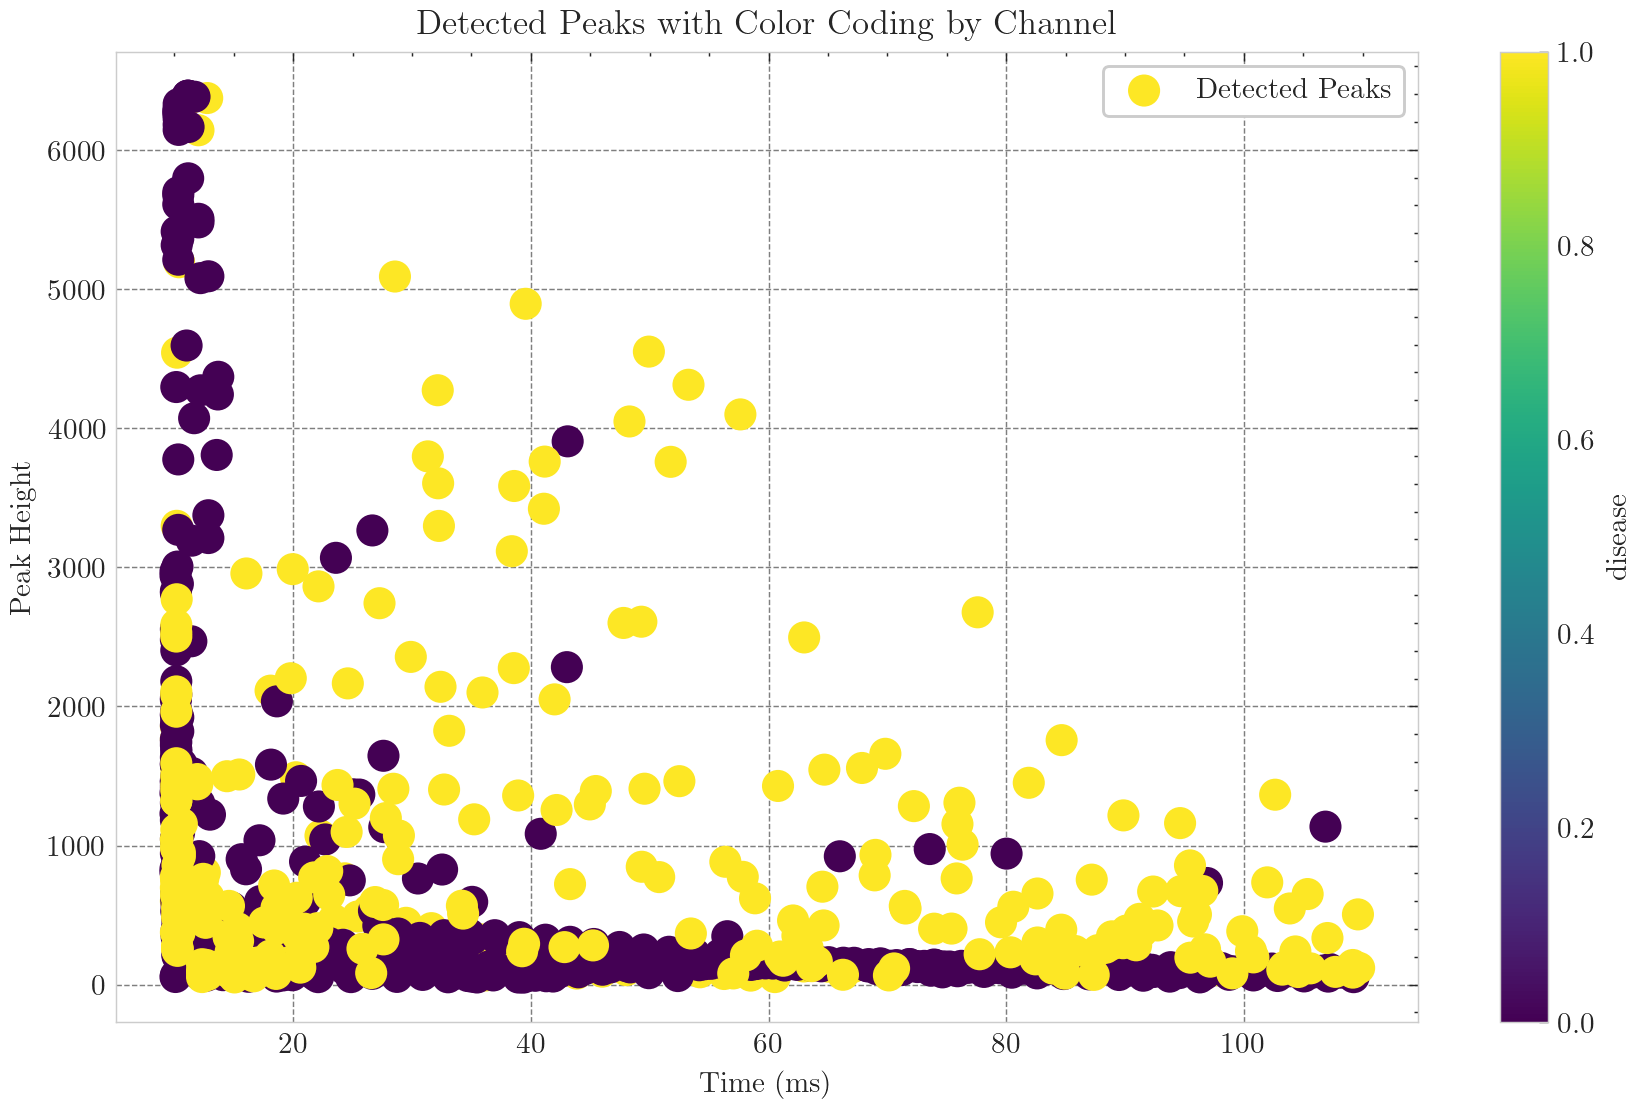

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fomo/Documents/Kaizen/code/motor evoked potentials/notebooks/Users/fomo/Desktop/peaks.png'

<Figure size 350x262.5 with 0 Axes>

In [7]:
# peak positions in milliseconds 
peak_positions_ms = [peak_position * (1000 / 30000) for _, peak_position, _ in detected_peaks]
peak_heights = [peak_height for _, _, peak_height in detected_peaks]
diseased = [i for i, _, _ in detected_peaks]  

# plot with colors based on a variable
plt.figure(figsize=(10, 6), dpi=210)
plt.scatter(peak_positions_ms, peak_heights, c=diseased, cmap='viridis', label='Detected Peaks', s=100)
plt.colorbar(label='disease')
plt.xlabel('Time (ms)')
plt.ylabel('Peak Height')
plt.title('Detected Peaks with Color Coding by Channel')
plt.legend()
plt.show()
plt.savefig('Users/fomo/Desktop/peaks.png')